<a href="https://colab.research.google.com/github/masalha-alaa/gender-prediction/blob/master/gender_recognition_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive

from collections import OrderedDict
from collections import Counter
from enum import Enum
import re
!pip install emoji
import emoji
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import scipy.sparse as sp
from multiprocessing import Pool, cpu_count

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import callbacks, layers

from datetime import datetime
import numpy as np
import pandas as pd

from pathlib import Path
import zipfile
from pickle import load, dump

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

import string
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import itertools

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk import word_tokenize
from nltk import data as nltk_data, pos_tag
from nltk.sentiment import SentimentIntensityAnalyzer


SEED = 42
BATCH_SIZE = 64
NGRAM_LEN = (1)
MOST_COMMON = 1150

     |████████████████████████████████| 170 kB 5.6 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=70db9ee43c2b3e8613e3aaaa6faddd14c108899229fd1fa1bb590eb31a9fd960
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Dataframe columns
TEXT = 'txt'
URL = 'url'
AUTHOR = 'author'
LABEL = GENDER = 'gender'

In [4]:
def clean_line_parallel(params):
    part, emoticons_ = params
    return part.apply(lambda row: clean_line(row, emoticons_))


def clean_line(line, emos=None):
    if not line:
        return ''
    EMOJI = r'emj'
    URL = r'url'
    PUNCT = r'pnc'
    remove = ['your comment has been removed', 'this comment or post has been removed', 'removed ', 'removed. ',
              'your submission has been remove', 'this post has been removed', 'your post has been removed']
    line = line.lower()
    if any(re.match(r, line) for r in remove):
        return ''
    line = emoji.get_emoji_regexp().sub(EMOJI, line)
    if emos is None:
        emoticons_ = emoticons
    else:
        emoticons_ = emos
    for emoticon in emoticons_:
        line = line.replace(emoticon, EMOJI)
    line = re.sub(r'\(?http\S+\)?', URL, line)
    return line


def posify(txt):
    """
    Converts txt to part of speech tags
    """
    return ' '.join([pair[1] for pair in pos_tag(txt.split())])


def posifyNew(txt):
    """
    Converts txt to pairs of word & POS
    """
    return ' '.join([' '.join(pos) for pos in pos_tag(txt.split())])


def posifyNew2(txt):
    """
    Appends pos text to txt
    """
    return txt + ' ' + ' '.join([pos[1] for pos in pos_tag(txt.split())])



def tokenize(txt):
    # return ' '.join(word_tokenize(clean_line(txt)))
    # return clean_line(txt)
    return ' '.join(word_tokenize(txt))


def sentecize(txt):
    return tokenizer.tokenize(txt)


def aggregate(df, sentences_n=4):
    df_agg = df.groupby(df.index // sentences_n).agg({'txt': ' '.join, 'pos': ' '.join, 'gender': 'first'}).reset_index(drop=True).copy()
    return df_agg

In [5]:
ts = datetime.now()
print('Program started')
print(f'{ts}\n')

EMOJI = r'emj'
URL = r'url'
MALE, FEMALE = 0, 1
PRECUT = 0.30
CLASS_SIZE = None  # None to take min max
SELECT_K_BEST = 100
TRAIN_FRAC = 0.70
MIN_SENT_LEN = 5  # in tokens  # TODO: Do some trials

DRIVE_ROOT_DATA_DIR = Path("/content/gdrive/MyDrive/gender-project/")
EXTRA_DIR = DRIVE_ROOT_DATA_DIR / "extra"
EMOTICONS_LST_FILE = "emoticons.txt"
FUNCTION_WORDS_LST_FILE = "fw.txt"

# read dataset
data = pd.read_csv(DRIVE_ROOT_DATA_DIR / "dataset3 and 2021-11-06 19-51-29" / "raw" / "data.csv")
if 0 < PRECUT < 1:
    data = data.sample(frac=PRECUT, random_state=SEED)

data = data.drop(data[(data.gender != 'male') & (data.gender != 'female')].index).reset_index(drop=True)

# Clean
clean_ts = datetime.now()
print('Cleaning...', end=' ')
with open(EXTRA_DIR / EMOTICONS_LST_FILE) as f:
    emoticons = [emoticon.lower() for emoticon in list(set(f.read().split()))]
if MIN_SENT_LEN > 1:
    # TODO: Ditch short before or after exploding?!
    data[data.txt.str.split().apply(len) < MIN_SENT_LEN] = ''
    # data = data[data.txt.str.split().apply(len) >= MIN_SENT_LEN].reset_index(drop=True)

# PARALLEL BEGIN
pools = cpu_count()
with Pool(pools) as pool:
    groups = [(part, emoticons) for part in np.array_split(data['txt'], pools)]
    data['txt'] = pd.concat(pool.map(clean_line_parallel, groups), axis=0)
# PARALLEL END

data = data.replace('', np.nan).dropna().reset_index(drop=True)
print(datetime.now() - clean_ts)

# split to genders
print('Splitting to genders...')
male = data.loc[data['gender'] == 'male', ['txt']]
female = data.loc[data['gender'] == 'female', ['txt']]

# tokenize
tokeniz_ts = datetime.now()
print('Tokenzing...', end=' ')
male['txt'] = male['txt'].apply(tokenize)
female['txt'] = female['txt'].apply(tokenize)
print(datetime.now() - tokeniz_ts)

# split to sentences
print('Splitting to sentences...')
tokenizer = nltk_data.load('tokenizers/punkt/english.pickle')
male = male.apply(lambda row: sentecize(row['txt']), axis=1).explode('txt').apply(lambda row: row.strip()).replace('', np.nan).dropna().to_frame('txt').copy().reset_index(drop=True)
female = female.apply(lambda row: sentecize(row['txt']), axis=1).explode('txt').apply(lambda row: row.strip()).replace('', np.nan).dropna().to_frame('txt').copy().reset_index(drop=True)

# sentiment analysis per sentence
def createSentiments(ser, sia):
    sentiments = ser.apply(lambda row: {k:v for k,v in sia.polarity_scores(row).items() if k != 'compound'})
    return sentiments

print('Sentiment analysis...', end=' ')
sia_ts = datetime.now()
sia = SentimentIntensityAnalyzer()
sentiments = createSentiments(male['txt'], sia)
male['txt'] = male.apply(lambda row: row['txt'] + ' ' + max(sentiments[row.name], key=sentiments[row.name].get), axis=1)
sentiments = createSentiments(female['txt'], sia)
female['txt'] = female.apply(lambda row: row['txt'] + ' ' + max(sentiments[row.name], key=sentiments[row.name].get), axis=1)
print(datetime.now() - sia_ts)
print(f"Example: {male['txt'][0]}")

# posify
print('Posifying...', end=' ')
ts_pos = datetime.now()
with Pool(cpu_count()) as pool:
    # only pos
    # male['pos'] = pool.map(posify, male['txt'])
    # female['pos'] = pool.map(posify, female['txt'])
    # txt and pos together
    male['pos'] = pool.map(posifyNew, male['txt'])
    female['pos'] = pool.map(posifyNew, female['txt'])
print(datetime.now() - ts_pos)

# add labels
print('Adding labels...')
male['gender'] = [MALE] * len(male)
female['gender'] = [FEMALE] * len(female)

# sample randomly and aggregate
select_n = CLASS_SIZE if CLASS_SIZE and CLASS_SIZE <= min(len(male), len(female)) else min(len(male), len(female))
print(f'Class size: {select_n}')
print('Shuffling and aggregating...')
male = male.sample(n=select_n, random_state=SEED).reset_index(drop=True)
female = female.sample(n=select_n, random_state=SEED).reset_index(drop=True)
male = aggregate(male)
female = aggregate(female)
print(f'Class size (M,F): {len(male)}, {len(female)}')

# merge and shuffle
print('Merging and shuffling...')
data = pd.concat([male, female]).reset_index(drop=True).sample(frac=1.0, random_state=SEED).reset_index(drop=True)

# split to train / test
print('Splitting to train / test...')
test = data.iloc[int(len(data) * TRAIN_FRAC):].reset_index(drop=True)
train = data.iloc[:int(len(data) * TRAIN_FRAC)]
print(f'Train size: {len(train)}')
print(f'Test size: {len(test)}')

Program started
2021-12-04 19:33:37.197250

Cleaning... 0:00:49.559692
Splitting to genders...
Tokenzing... 0:00:17.620430
Splitting to sentences...
Sentiment analysis... 0:00:30.194586
Example: it helpdesk nerd combined with being linux sysadmin nerd neu
Posifying... 0:01:46.849101
Adding labels...
Class size: 45898
Shuffling and aggregating...
Class size (M,F): 11475, 11475
Merging and shuffling...
Splitting to train / test...
Train size: 16064
Test size: 6886


In [6]:
# Convert to tensorflow dataset

# Choose:
# DATA = TEXT
DATA = 'pos'

train_dataset = tf.data.Dataset.from_tensor_slices((train[DATA], keras.utils.to_categorical(train[LABEL])))
test_dataset = tf.data.Dataset.from_tensor_slices((test[DATA], keras.utils.to_categorical(test[LABEL])))

train_dataset = train_dataset.shuffle(train.shape[0]).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(test.shape[0]).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train, test = None, None

1150 [('NN', 301444), ('.', 160920), ('IN', 141341), ('JJ', 109581), ('RB', 108202), ('PRP', 106969), ('DT', 99770), (',', 96108), ('VB', 87249), ('neu', 84205), ('VBP', 67511), ('NNS', 63383), ('CC', 57556), ('i', 49594), ('VBZ', 45410), ('VBD', 40851), ('TO', 39842), ('to', 39476), ('and', 35567), ('VBG', 35040)]
Min occurrences: ('birthday', 105)


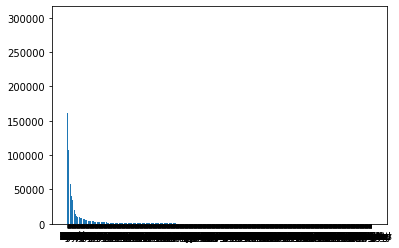

In [7]:
vocab = Counter()
# junk = data[DATA].str.split().apply(vocab.update)
junk = data[DATA].apply(lambda x: vocab.update(x.split()))
junk = None
vocab = vocab.most_common(MOST_COMMON)
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(standardize=None, vocabulary=list(set([k for k,_ in vocab])), ngrams=NGRAM_LEN)
# encoder.adapt(train_dataset.map(lambda text, label: text))  # not needed, because we passed the vocabulary manually
print(len(vocab), vocab[:20])
print(f'Min occurrences: {vocab[-1]}')
plt.bar(*zip(*vocab))
vocab = None

In [8]:
random.sample(encoder.get_vocabulary(), 40)

['VBZ',
 'CD',
 'anymore',
 ';',
 'therapy',
 'level',
 'appreciate',
 'current',
 'local',
 'laugh',
 'everything',
 'dad',
 'starting',
 'step',
 'months',
 'course',
 'text',
 'these',
 'known',
 'places',
 'simple',
 'character',
 'EX',
 ',',
 'problems',
 'gf',
 'knowing',
 'needs',
 'pressure',
 'favorite',
 'speaking',
 'IN',
 'others',
 'some',
 'common',
 'currently',
 'average',
 'thing',
 'real',
 'fucking']

In [9]:
for example, label in train_dataset.take(1):
    print('text: ', example.numpy()[:3])
    print('label: ', label.numpy()[:3])

text:  [b'i NN got VBD on IN my PRP$ dream NN training NN programme NN and CC had VBD to TO move VB away RB for IN it PRP . . neu CC i NN think VBP that IN no DT loving JJ husband NN or CC father NN could MD see VB his PRP$ wife NN go VBP through IN the DT kind NN of IN postpartum NN psychosis NN she PRP went VBD through IN and CC think VB \xe2\x80\x9c NNP let VB \xe2\x80\x99 NNP s VB have VBP another DT ! . neu NN if IN she PRP ignored VBD you PRP , , that WDT shows VBZ to TO me PRP that IN she PRP does VBZ not RB want VB you PRP to TO interact VB with IN her PRP at IN all DT though IN , , so RB in IN your PRP$ situation NN , , i NN would MD ignore VB her PRP as RB well RB . . neu NN so RB forcefully RB separating VBG the DT mother NN is VBZ okay JJ but CC running VBG away RB with IN it PRP due JJ to TO a DT toxic JJ environment NN is VBZ not RB ? . neu NNS'
 b"> NN apparently RB she PRP has VBZ a DT crush NN on IN him PRP congratulations NNS , , your PRP$ girlfriend NN is VBZ now RB 

In [10]:
MODEL = 1
save_path = DRIVE_ROOT_DATA_DIR / "keras_lstm_model_TEMP"

print('Creating model...')
if MODEL == 1:
    model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=100,
            # Use masking to handle the variable sequence lengths
            mask_zero=False),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
        # tf.keras.layers.Dense(128, activation='relu'),
        # tf.keras.layers.Dense(2)
        tf.keras.layers.Dense(2, activation='softmax')
    ])

else:
    model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 100, mask_zero=True),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
        # tf.keras.layers.Dense(64, activation='relu'),
        # tf.keras.layers.Dropout(0.5),
        # tf.keras.layers.Dense(2)
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation='softmax')
    ])

def lr_scheduler(epoch, lr):
    if epoch > 0 and epoch % 5 == 0:
        return lr * 0.5
    return lr

my_callbacks = [callbacks.LambdaCallback(on_epoch_end=lambda epoch,logs: model.save(save_path) if epoch % 5 == 0 else None),
                callbacks.EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True),]
                #callbacks.LearningRateScheduler(lr_scheduler),]
                # callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_delta=0.01, min_lr=1e-5, patience=3, verbose=1)]
loss_func = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model.compile(loss=loss_func,
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


# TEST:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

# for i in range(len(encoded_lbls)):
#     print(loss_func(predictions[0], keras.utils.to_categorical(i, num_classes=len(encoded_lbls))).numpy())

Creating model...
[0.5016295 0.4983705]
[0.50104094 0.49895906]


In [11]:
with tf.device('/gpu:0'):
    history = model.fit(train_dataset, epochs=20, validation_data=test_dataset, callbacks=my_callbacks)
model.save(save_path)
print(f'Model saved to: {save_path}')

Epoch 1/20
251/251 [==============================] - ETA: 0s - loss: 0.6921 - accuracy: 0.5250

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/gender-project/keras_lstm_model_TEMP/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/gender-project/keras_lstm_model_TEMP/assets


251/251 [==============================] - 71s 268ms/step - loss: 0.6921 - accuracy: 0.5250 - val_loss: 0.6881 - val_accuracy: 0.5273
Epoch 2/20
251/251 [==============================] - 48s 191ms/step - loss: 0.6603 - accuracy: 0.6099 - val_loss: 0.6500 - val_accuracy: 0.6297
Epoch 3/20
251/251 [==============================] - 49s 194ms/step - loss: 0.6240 - accuracy: 0.6560 - val_loss: 0.6162 - val_accuracy: 0.6628
Epoch 4/20
251/251 [==============================] - 49s 195ms/step - loss: 0.6060 - accuracy: 0.6764 - val_loss: 0.6043 - val_accuracy: 0.6721
Epoch 5/20
251/251 [==============================] - 49s 195ms/step - loss: 0.5855 - accuracy: 0.6928 - val_loss: 0.5990 - val_accuracy: 0.6801
Epoch 6/20
251/251 [==============================] - ETA: 0s - loss: 0.5732 - accuracy: 0.7052

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/gender-project/keras_lstm_model_TEMP/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/gender-project/keras_lstm_model_TEMP/assets


251/251 [==============================] - 65s 259ms/step - loss: 0.5732 - accuracy: 0.7052 - val_loss: 0.6015 - val_accuracy: 0.6744
Epoch 7/20
251/251 [==============================] - 48s 193ms/step - loss: 0.5658 - accuracy: 0.7113 - val_loss: 0.6126 - val_accuracy: 0.6708
Epoch 8/20
251/251 [==============================] - 48s 193ms/step - loss: 0.5595 - accuracy: 0.7120 - val_loss: 0.5993 - val_accuracy: 0.6799
Epoch 9/20
251/251 [==============================] - 49s 193ms/step - loss: 0.5547 - accuracy: 0.7144 - val_loss: 0.5930 - val_accuracy: 0.6779


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/gender-project/keras_lstm_model_TEMP/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/gender-project/keras_lstm_model_TEMP/assets


Model saved to: /content/gdrive/MyDrive/gender-project/keras_lstm_model_TEMP


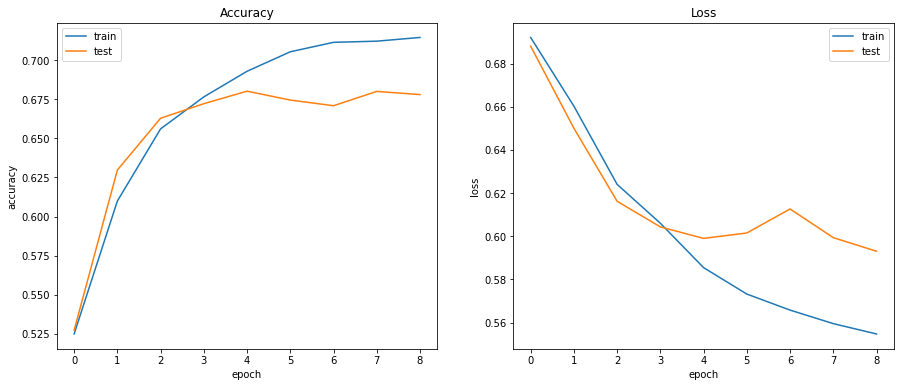

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))
axs[0].set_title('Accuracy')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('accuracy')
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].legend(['train', 'test'])

axs[1].set_title('Loss')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('loss')
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].legend(['train', 'test'])

In [13]:
keras.models.load_model(save_path)